### Error Analysis for Intermediate Regime

This notebook make an analysis the compatibility of the polynomial fir for forces found for the dipole regime and forces computed by th Optical Tweezers Toolbox for MATLab. The forces were computed in the OTT for different values of particle radius and numerical aberture (NA). If the fit presents a small error is possible to conclude that the expression is still valid for the intermediate regime and, as a consequence, for the regime in which the experiment has been conducted.

A brief summary of the organization of this notebook:

### Summary

- [1 - Packages and imports](#1)

- [2 - Load data from simulations](#2)

- [3 - Forces analysis](#3)

<a name='1'></a> 
### 1. Packages and imports

In [2]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import os

plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2
plt.rcParams.update({'font.size': 15})

<a name='2'></a> 
### 2. Load data from simulations

Defining the `load_data` function to read a `.mat` file and reescale it for the fits.

In [3]:
simulations_path = '../data/simulations/error_analysis'

In [4]:
def load_data(filepath):
    mat_file = loadmat(filepath)
    fr = mat_file['fr']
    fz = mat_file['fz']
    r = mat_file['r']
    z = mat_file['z']
    x = 10**8*r[0,inf:sup]
    y = 10**8*r[1,inf:sup]
    z = 10**8*z[2,inf:sup]
    fx = 10**14*fr[0,inf:sup]
    fy = 10**14*fr[1,inf:sup]
    fz = 10**14*fz[2,inf:sup]
    return x, y, z, fx, fy, fz

<a name='3'></a> 
### 3. Forces analysis

To analysis how good the polynomial approximation of the potential is, we are going to define the expression for the forces considering the gradient of potential presented in the paper. Such potential results in third order polynomial expressions for $F_x$ and $F_y$, and first order for the $z$ direction.

In [5]:
def Fx(x, k1, k2, k3):
    return k1*np.power(x,3)+k2*np.power(x,1)+k3

def Fy(y, k1, k2, k3):
    return k1*np.power(x,3)+k2*np.power(x,1)+k3

def Fz(z, k1, k2):
    return k1*z + k2

The `compute_error` function receives the function for a specific axis, the values for the axis and for the forces, and also the number of coefficientes the functions has. With these is possible to compute RMSE (root mean squared error) for each axis.

In [6]:
def compute_error(function, x_axis, function_values, p0_size):
    params, _ = curve_fit(function, x_axis, function_values, p0=np.random.rand(p0_size))
    fitted_curve = function(x_axis, *params)
    return np.sqrt(np.power((fitted_curve - function_values),2).mean())/np.sqrt(np.power(function_values,2).mean())

In [7]:
errors, axis, NAs, radiuss = [], [], [], []
for file in os.listdir(simulations_path):
    inf = 220
    sup = 280
    if file.split('.')[-1] != 'mat':
        continue
    splitted = file.split('-')
    NA = float(splitted[0])
    radius = float(splitted[1][:-3])
    radiuss.append(radius)
    NAs.append(NA)
    x, y, z, fx, fy, fz = load_data(f'{simulations_path}/{file}')
    error = compute_error(Fx, x, fx, 3)
    errors.append(error)
    axis.append('x')
    error = compute_error(Fy, y, fy, 3)
    errors.append(error)
    radiuss.append(radius)
    NAs.append(NA)
    axis.append('y')
    error = compute_error(Fz, z, fz, 2)
    errors.append(error)
    axis.append('z')
    radiuss.append(radius)
    NAs.append(NA)



/Users/oscarkremer/miniconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [8]:
np.array(errors).mean()

0.0049842368129669

In [9]:
df = pd.DataFrame()
df['na'] = NAs
df['radius'] = radiuss
df['error'] = errors
df['axis'] = axis

In [10]:
grouped_df = df.groupby(by=['na', 'radius'], as_index=False).mean()
grouped_df.head(3)

,na,radius,error
0,40.0,50.0,0.000625
1,40.0,70.0,0.000509
2,40.0,350.0,0.000733


In [11]:
df['na'].unique()
na_plot = np.arange(40, 62, 2).astype(int)

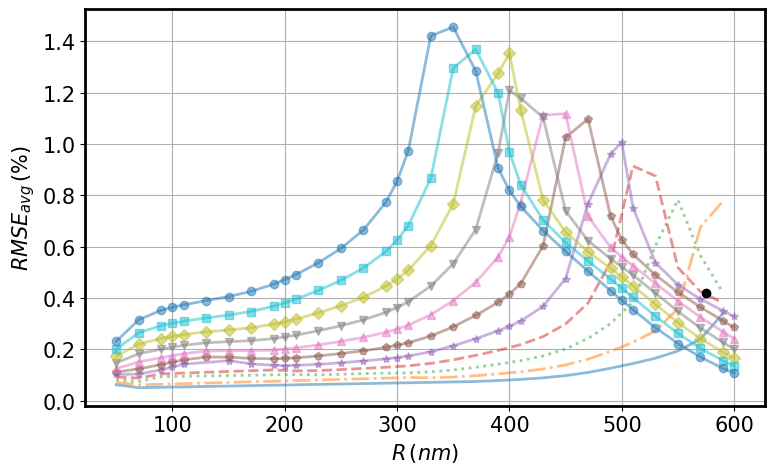

In [14]:
legends = []
grouped_df = grouped_df.sort_values(by=['na'])
markers = ['']
linestyle = ['-', '-.', ':', '--', '-', '-', '-', '-', '-', '-','-']
markers = ['', '', '', '', '*', 'p', '^', 'v', 'D', 's', 'o', 'x']
index = 0


fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(5)

for na in grouped_df['na'].unique():
    if int(na) in na_plot:
        select_df = grouped_df[grouped_df['na']==na]
        select_df = select_df.sort_values(by=['radius'])
        ax.plot(select_df['radius'].values, 100*select_df['error'].values, 
                 linestyle=linestyle[index], marker=markers[index], linewidth=2, markersize=6, alpha=0.5)
        index += 1
ax.plot(575, 0.42, 'ko')
ax.grid()
ax.set_ylabel(r'$RMSE_{avg}\,(\%)$')
ax.set_xlabel(r'$R\,(nm)$')
#plt.legend(legends, title='NA')
plt.savefig('error_plot.pdf', dpi=300)
plt.show()